In [159]:
import warnings
warnings.filterwarnings('ignore') ## silent non-critical warnings

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pd.options.display.max_colwidth = 100
# %matplotlib inline

In [ ]:
# Load dataset
df = pd.read_csv('datasets/df_preprocessing.csv')

# Ambil kolom 'stemming_indo' sebagai corpus
corpus = np.array(df['stemming_indo'])
corpus_df = pd.DataFrame({'Document': corpus})

# Bersihkan kata 'kompas com' dan 'kompas.com'
corpus_df['Document'] = corpus_df['Document'].str.replace(r'\bkompas\s*\.?\s*com\b', '', regex=True, case=False)

# Hilangkan spasi ganda yang tersisa setelah penghapusan
corpus_df['Document'] = corpus_df['Document'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Cek hasil
corpus_df.head()

,Document
0,menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut permenpora ...
1,manajer chelsea enzo maresca anggap sulit henti liverpool tahan gelar juara liga inggris musim i...
2,latih liverpool arne slot aku crystal palace milik kuat patut hitung liverpool racik slot tumban...
3,hasil baru pekan liga italia beda nasib juventus inter mil main allianz stadium turin sabtu mala...
4,menteri pemuda olahraga republik indonesia menpora ri erick thohir dukung dana ikut sea games th...


In [161]:
# ANALISIS DATASET
print("=" * 60)
print("ANALISIS DATASET AWAL")
print("=" * 60)

print(f"\nJumlah dokumen: {len(df)}")
print(f"\nDistribusi kategori berita:")
print(df['Kategori Berita'].value_counts())

print(f"\nKolom yang tersedia:")
print(df.columns.tolist())

print(f"\nContoh data stemming_indo:")
print(df['stemming_indo'].head(3))

ANALISIS DATASET AWAL

Jumlah dokumen: 1200

Distribusi kategori berita:
Kategori Berita
BOLA        200
MONEY       200
NEWS        200
OTOMOTIF    200
PROV        200
REGIONAL    200
Name: count, dtype: int64

Kolom yang tersedia:
['Isi Berita', 'lwr_indo', 'clean_sw_indo', 'clean_stb_indo', 'clean_typo_indo', 'stemming_indo', 'tokenize_indo', 'Kategori Berita']

Contoh data stemming_indo:
0    kompas com menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut ...
1    kompas com manajer chelsea enzo maresca anggap sulit henti liverpool tahan gelar juara liga ingg...
2    kompas com latih liverpool arne slot aku crystal palace milik kuat patut hitung liverpool racik ...
Name: stemming_indo, dtype: object


## Preprocessing

In [162]:
# Initialize tokenizer
wpt = nltk.WordPunctTokenizer()

# Fungsi normalisasi tanpa stopword dan tanpa stemming
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)  # Hapus simbol/punctuation
    #Hapus "kompas com" 
    doc = re.sub(r'\bkompas\s*com\b', '', doc)
    doc = re.sub(r'\bkompas\.com\b', '', doc)
    doc = doc.lower().strip()  # lowercase + hilangkan spasi depan/belakang
    tokens = wpt.tokenize(doc)  # tokenisasi kata
    doc = ' '.join(tokens)  # gabungkan lagi jadi satu string
    return doc

# Vectorize function agar bisa diterapkan ke array / DataFrame
normalize_corpus = np.vectorize(normalize_document)

In [163]:
## proprocess corpus
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut permenpora no tuai polemik kalang laku olahraga menpora erick thohir deregulasi besar besar mangkas atur menteri maksimal atur langkah sambut positif pihak amat sepak bola nasional sit b handoyo sebab putus jalan ekspektasi publik olahraga baca juga erick thohir terobos menpora koni jatim apresiasi cabut permenpora bagus atur rancu standar kelola organisasi olahraga prestasi tumpang tindih pria sapa sit khawatir independensi cabang olahraga sirna campur tangan langsung perintah kalau cabut kabar cabang olahraga kritisi atur sebut ini terobos bagus minggu minggu pertama saja erick gebrak tunggu tunggu langsung laku putus tugas menpora imbuh sit nilai rencana sederhana permenpora no atur pasti dunia olahraga baca juga sosok fifa korban hoaks indonesia erick thohir seret lama atur tumpang tindih bingung masyarakat olahraga sisi boleh sisi atur larang atur sederhana bagus sit b handoyo fokus jelas 

## Bag of Words Model

In [164]:
## CountVectorizer dengan parameter yang lebih baik untuk topic modeling
# min_df: hilangkan kata yang muncul di < 2 dokumen (terlalu jarang)
# max_df: hilangkan kata yang muncul di > 95% dokumen (terlalu umum, seperti stopword)
# max_features: batasi hanya 5000 kata paling penting (opsional)

cv = CountVectorizer(
    min_df=2,           # minimal muncul di 2 dokumen
    max_df=0.95,        # maksimal muncul di 95% dokumen
    max_features=5000   # ambil 5000 kata teratas
)
cv_matrix = cv.fit_transform(norm_corpus)

print(f"Ukuran vocabulary setelah filtering: {len(cv.get_feature_names_out())}")
print(f"Shape matrix: {cv_matrix.shape}")
cv_matrix

Ukuran vocabulary setelah filtering: 5000
Shape matrix: (1200, 5000)


<1200x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 132688 stored elements in Compressed Sparse Row format>

In [165]:
## Inspect BOA matrix
## warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [166]:
## Check all lexical features
vocab = cv.get_feature_names_out()

## View BOA in df
pd.DataFrame(cv_matrix, columns=vocab)

,aan,abad,abadi,abai,abang,abdi,abdul,abdullah,abimanyu,abiyoso,...,zenix,zero,zidane,zijlstra,zona,zoo,zulfikar,zulhas,zulkifli,zwolle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Intuition of LDA

### Building LDA Model

In [167]:
## Building LDA Model dengan parameter yang lebih baik
lda = LatentDirichletAllocation(
    n_components=6,              # 6 topik sesuai 6 kategori
    max_iter=50,                 # maksimal iterasi
    learning_method='online',    # lebih cepat untuk dataset besar
    learning_offset=50.0,        # kontrol learning rate
    random_state=42,             # reproducibility
    n_jobs=-1                    # gunakan semua CPU core
)
doc_topic_matrix = lda.fit_transform(cv_matrix)
print('LDA model trained!')
print(f'Number of iterations: {lda.n_iter_}')

LDA model trained!
Number of iterations: 50


### Model Performance Metrics

In [168]:
## log-likelihood
print(lda.score(cv_matrix))

## perplexity
print(lda.perplexity(cv_matrix))

-1668942.076244743
1483.8125125644879
1483.8125125644879


### Interpretation

In [169]:
print(doc_topic_matrix.shape) ## doc-by-topic matrix
print(lda.components_.shape) ## topic-by-word- matrix

(1200, 6)
(6, 5000)


### Document-by-Topic Matrix

In [170]:
## doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3','T4', 'T5','T6'])
doc_topic_df

,T1,T2,T3,T4,T5,T6
0,0.000778,0.051443,0.585869,0.006936,0.051278,0.303696
1,0.000814,0.064979,0.000811,0.000809,0.931778,0.000809
2,0.000839,0.000844,0.000838,0.000836,0.995804,0.000839
3,0.000884,0.000885,0.000884,0.000884,0.995576,0.000887
4,0.000864,0.481746,0.062041,0.000863,0.177614,0.276872
...,...,...,...,...,...,...
1195,0.001164,0.001162,0.994183,0.001169,0.001161,0.001161
1196,0.034928,0.000952,0.487077,0.263934,0.000952,0.212157
1197,0.001104,0.001105,0.994485,0.001102,0.001102,0.001103
1198,0.001225,0.001221,0.993886,0.001220,0.001221,0.001226


### Topic-by-Word Matrix

In [171]:
topic_word_matrix = lda.components_

In [172]:
pd.DataFrame(topic_word_matrix, columns=vocab)

,aan,abad,abadi,abai,abang,abdi,abdul,abdullah,abimanyu,abiyoso,...,zenix,zero,zidane,zijlstra,zona,zoo,zulfikar,zulhas,zulkifli,zwolle
0,0.169524,2.006003,2.086428,8.898724,0.170359,0.167064,14.254594,0.166798,0.166679,5.845760,...,5.833982,0.170284,0.166675,0.166681,0.167455,0.166680,0.166828,0.166858,0.166711,0.166691
1,0.166864,0.166675,8.242061,2.152576,0.166809,0.167862,0.166920,0.167810,0.171281,0.166676,...,0.166955,0.191965,0.171922,0.166677,10.083338,0.166675,0.167691,0.167051,0.167339,0.166714
2,8.579546,4.029760,0.168013,2.562114,8.598334,8.643291,42.856429,7.622055,9.579730,0.166679,...,0.166681,7.612730,0.166677,0.166692,8.046586,1.444695,7.570986,22.039190,18.096101,0.166692
3,0.166676,0.166678,0.167684,1.092821,0.169968,8.430096,0.171749,0.166786,0.166680,0.166674,...,0.166674,0.166795,0.166906,0.166675,2.811356,6.707929,0.166675,0.166677,0.166674,0.166676
4,0.166674,1.053705,1.056266,0.166693,0.166679,1.064210,0.167362,8.176628,0.166682,0.166677,...,0.166675,0.166675,8.155086,5.521531,38.640228,0.166857,0.166676,0.166676,0.166676,6.375682
5,0.166675,0.167591,0.167450,0.166852,0.167801,0.182237,0.169143,1.729527,0.166675,0.166675,...,0.166674,0.166676,0.167000,0.166675,0.167400,0.167618,0.166676,0.166676,0.166675,0.166848


In [173]:
pd.DataFrame(np.transpose(topic_word_matrix), index=vocab)

,0,1,2,3,4,5
aan,0.169524,0.166864,8.579546,0.166676,0.166674,0.166675
abad,2.006003,0.166675,4.029760,0.166678,1.053705,0.167591
abadi,2.086428,8.242061,0.168013,0.167684,1.056266,0.167450
abai,8.898724,2.152576,2.562114,1.092821,0.166693,0.166852
abang,0.170359,0.166809,8.598334,0.169968,0.166679,0.167801
...,...,...,...,...,...,...
zoo,0.166680,0.166675,1.444695,6.707929,0.166857,0.167618
zulfikar,0.166828,0.167691,7.570986,0.166675,0.166676,0.166676
zulhas,0.166858,0.167051,22.039190,0.166677,0.166676,0.166676
zulkifli,0.166711,0.167339,18.096101,0.166674,0.166676,0.166675


### Interpreting the Meanings of Topics

In [174]:
## customized function

def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    """
    This function sorts the words importance under each topic and 
    allows selecting words based on ranks or a cutoff on weights.

    Parameters:
    - tw_m : array-like
        Topic by Word matrix containing the weights of each word in each topic.
    - vocab : list
        List of words in the vocabulary.
    - display_weights : bool, optional (default=False)
        Flag to indicate whether to display words with their weights.
    - topn : int, optional (default=5)
        Number of top words to display for each topic if display_weights is False.
    - weight_cutoff : float, optional (default=0.6)
        Weight cutoff threshold for displaying words if display_weights is True.
    """
    for i, topic_weights in enumerate(tw_m):
        topic = [(token, np.round(weight, 2)) for token, weight in zip(vocab, topic_weights)]
        topic = sorted(topic, key=lambda x: -x[1])
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff]
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

In [175]:
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('mobil', 573.66), ('kendara', 559.2), ('listrik', 512.33), ('motor', 445.1), ('jalan', 443.75), ('jakarta', 390.68), ('rp', 331.8), ('milik', 303.16), ('indonesia', 288.61), ('harga', 287.89), ('bbm', 237.63), ('bakar', 218.46), ('mesin', 205.36), ('hadir', 197.18), ('guna', 191.44), ('resmi', 188.39), ('tol', 186.98), ('pertamina', 180.14), ('beli', 177.27), ('jual', 176.71), ('unit', 175.84), ('masyarakat', 173.52), ('spbu', 167.19), ('ini', 165.13), ('lintas', 162.87), ('honda', 160.13), ('bahan', 158.26), ('kai', 157.86), ('juta', 156.1), ('sesuai', 154.91), ('shell', 154.12), ('suzuki', 153.28), ('itu', 149.25), ('kota', 147.66), ('imos', 147.45), ('kondisi', 146.03), ('cepat', 136.47), ('alternator', 134.39), ('pakai', 133.96), ('konsumen', 129.95), ('september', 124.93), ('subsidi', 124.25), ('layan', 121.23), ('buka', 119.68), ('sedia', 116.16), ('salah', 115.33), ('pilih', 113.81), ('biaya', 113.69), ('tarif', 113.24), ('butuh', 111.07), ('kereta', 110.0), ('isi',

In [176]:
get_topics_meanings(topic_word_matrix, 
                    vocab, 
                    display_weights=False, 
                    topn=5)

Topic #0 :
mobil kendara listrik motor jalan
Topic #1 :
rp indonesia persen harga emas
Topic #2 :
mbg korban anak makan rumah
Topic #3 :
gempa ppp laut puasa sidang
Topic #4 :
main laga gol vs tim
Topic #5 :
marquez motogp dunia balap indonesia
Topic #3 :
gempa ppp laut puasa sidang
Topic #4 :
main laga gol vs tim
Topic #5 :
marquez motogp dunia balap indonesia


## Topics in Documents

In [177]:
# Simpan label asli untuk evaluasi nanti
doc_topic_df['actual_category'] = df['Kategori Berita']
doc_topic_df['corpus'] = norm_corpus

# Tentukan topik dominan untuk setiap dokumen
doc_topic_df['dominant_topic'] = doc_topic_df[['T1', 'T2', 'T3', 'T4', 'T5', 'T6']].idxmax(axis=1)

doc_topic_df

,T1,T2,T3,T4,T5,T6,actual_category,corpus,dominant_topic
0,0.000778,0.051443,0.585869,0.006936,0.051278,0.303696,BOLA,menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut permenpora ...,T3
1,0.000814,0.064979,0.000811,0.000809,0.931778,0.000809,BOLA,manajer chelsea enzo maresca anggap sulit henti liverpool tahan gelar juara liga inggris musim i...,T5
2,0.000839,0.000844,0.000838,0.000836,0.995804,0.000839,BOLA,latih liverpool arne slot aku crystal palace milik kuat patut hitung liverpool racik slot tumban...,T5
3,0.000884,0.000885,0.000884,0.000884,0.995576,0.000887,BOLA,hasil baru pekan liga italia beda nasib juventus inter mil main allianz stadium turin sabtu mala...,T5
4,0.000864,0.481746,0.062041,0.000863,0.177614,0.276872,BOLA,menteri pemuda olahraga republik indonesia menpora ri erick thohir dukung dana ikut sea games th...,T2
...,...,...,...,...,...,...,...,...,...
1195,0.001164,0.001162,0.994183,0.001169,0.001161,0.001161,REGIONAL,karanganyar dapur satu layan penuh gizi sppg tegalarum cangak karanganyar jawa jateng relokasi p...,T3
1196,0.034928,0.000952,0.487077,0.263934,0.000952,0.212157,REGIONAL,bandung kepala stasiun geofisika bmkg bandung teguh rahayu jelas fenomena awan tebal serta petir...,T3
1197,0.001104,0.001105,0.994485,0.001102,0.001102,0.001103,REGIONAL,tegal marak racun makan program makan gizi gratis mbg daerah perintah kota tegal jawa tengah ket...,T3
1198,0.001225,0.001221,0.993886,0.001220,0.001221,0.001226,REGIONAL,solo perintah kota pemkot solo jawa tengah blokir akun media sosial medsos isi konten simpang se...,T3


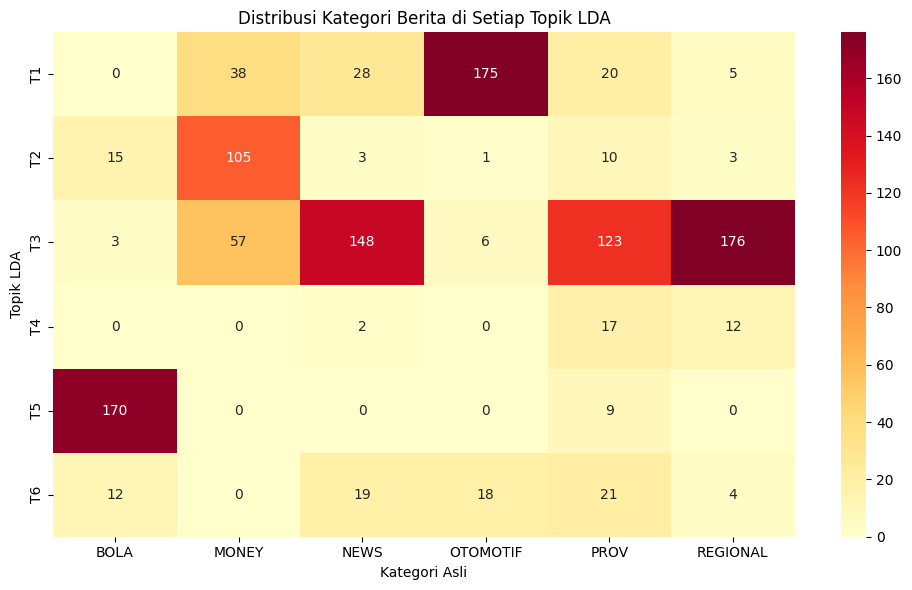

In [178]:
# Heatmap untuk melihat distribusi kategori di setiap topik
import seaborn as sns

crosstab = pd.crosstab(doc_topic_df['dominant_topic'], doc_topic_df['actual_category'])
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Distribusi Kategori Berita di Setiap Topik LDA')
plt.xlabel('Kategori Asli')
plt.ylabel('Topik LDA')
plt.tight_layout()
plt.show()

In [179]:
# Analisis korespondensi antara topik LDA dengan kategori asli
print("Distribusi Kategori Asli per Topik LDA:\n")
for topic in ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']:
    topic_docs = doc_topic_df[doc_topic_df['dominant_topic'] == topic]
    print(f"\n{topic}:")
    print(topic_docs['actual_category'].value_counts())
    print("-" * 50)

Distribusi Kategori Asli per Topik LDA:


T1:
actual_category
OTOMOTIF    175
MONEY        38
NEWS         28
PROV         20
REGIONAL      5
Name: count, dtype: int64
--------------------------------------------------

T2:
actual_category
MONEY       105
BOLA         15
PROV         10
NEWS          3
REGIONAL      3
OTOMOTIF      1
Name: count, dtype: int64
--------------------------------------------------

T3:
actual_category
REGIONAL    176
NEWS        148
PROV        123
MONEY        57
OTOMOTIF      6
BOLA          3
Name: count, dtype: int64
--------------------------------------------------

T4:
actual_category
PROV        17
REGIONAL    12
NEWS         2
Name: count, dtype: int64
--------------------------------------------------

T5:
actual_category
BOLA    170
PROV      9
Name: count, dtype: int64
--------------------------------------------------

T6:
actual_category
PROV        21
NEWS        19
OTOMOTIF    18
BOLA        12
REGIONAL     4
Name: count, dtype: int64
------

In [180]:
# Analisis mendalam: topik vs kategori
print("=" * 70)
print("ANALISIS KORESPONDENSI TOPIK LDA vs KATEGORI BERITA")
print("=" * 70)

for topic_num in range(6):
    topic_name = f'T{topic_num+1}'
    
    # Kata-kata dominan di topik ini
    print(f"\n{'='*70}")
    print(f"📊 {topic_name}")
    print(f"{'='*70}")
    
    # Top 10 kata di topik ini
    topic_words_idx = topic_word_matrix[topic_num].argsort()[-10:][::-1]
    topic_words = [vocab[i] for i in topic_words_idx]
    topic_weights = [topic_word_matrix[topic_num][i] for i in topic_words_idx]
    
    print(f"\n🔤 Top 10 Kata Dominan:")
    for word, weight in zip(topic_words, topic_weights):
        print(f"   {word:15s} : {weight:.4f}")
    
    # Dokumen dengan topik ini sebagai dominant
    topic_docs = doc_topic_df[doc_topic_df['dominant_topic'] == topic_name]
    
    print(f"\n📰 Jumlah dokumen dengan topik dominan {topic_name}: {len(topic_docs)}")
    
    if len(topic_docs) > 0:
        print(f"\n📈 Distribusi Kategori Berita:")
        category_dist = topic_docs['actual_category'].value_counts()
        for cat, count in category_dist.items():
            percentage = (count / len(topic_docs)) * 100
            print(f"   {cat:15s} : {count:4d} dokumen ({percentage:5.1f}%)")
        
        # Kategori dominan
        dominant_cat = category_dist.index[0]
        dominant_pct = (category_dist.iloc[0] / len(topic_docs)) * 100
        print(f"\n✅ Kategori Dominan: {dominant_cat} ({dominant_pct:.1f}%)")
        
        # Purity score untuk topik ini
        if dominant_pct < 50:
            print(f"   ⚠️  WARNING: Topik ini TIDAK MURNI (< 50% dari satu kategori)")
        elif dominant_pct < 70:
            print(f"   ⚡ MODERATE: Topik cukup jelas tapi ada campuran")
        else:
            print(f"   ✨ GOOD: Topik sangat jelas dan konsisten!")

print(f"\n{'='*70}")
print("SELESAI")
print(f"{'='*70}")

ANALISIS KORESPONDENSI TOPIK LDA vs KATEGORI BERITA

📊 T1

🔤 Top 10 Kata Dominan:
   mobil           : 573.6604
   kendara         : 559.2026
   listrik         : 512.3341
   motor           : 445.1032
   jalan           : 443.7549
   jakarta         : 390.6755
   rp              : 331.7975
   milik           : 303.1650
   indonesia       : 288.6107
   harga           : 287.8879

📰 Jumlah dokumen dengan topik dominan T1: 266

📈 Distribusi Kategori Berita:
   OTOMOTIF        :  175 dokumen ( 65.8%)
   MONEY           :   38 dokumen ( 14.3%)
   NEWS            :   28 dokumen ( 10.5%)
   PROV            :   20 dokumen (  7.5%)
   REGIONAL        :    5 dokumen (  1.9%)

✅ Kategori Dominan: OTOMOTIF (65.8%)
   ⚡ MODERATE: Topik cukup jelas tapi ada campuran

📊 T2

🔤 Top 10 Kata Dominan:
   rp              : 512.3131
   indonesia       : 444.8753
   persen          : 371.9784
   harga           : 336.5852
   emas            : 332.0399
   usaha           : 299.1448
   kerja           : 248.4

### Evaluasi Kualitas Topik dengan Coherence

Untuk menilai apakah topik yang dihasilkan "bermakna", kita perlu:
1. Lihat kata-kata yang dominan di setiap topik
2. Bandingkan dengan kategori yang paling banyak di topik tersebut
3. Hitung coherence score (optional, butuh library tambahan)

In [181]:
## initialize kmeans
km = KMeans(n_clusters=6, random_state=42)

## fit kmeans
km.fit(doc_topic_matrix)

## get cluster labels
cluster_labels = km.labels_

## check results
cluster_df = pd.DataFrame({
    'ClusterLabel': cluster_labels,
    'Document': corpus_df['Document'].values,
    'Actual_Category': df['Kategori Berita'].values
})

print(f"Jumlah dokumen per cluster:")
print(cluster_df['ClusterLabel'].value_counts().sort_index())

cluster_df.head(10)

Jumlah dokumen per cluster:
ClusterLabel
0    408
1    243
2     78
3    159
4    174
5    138
Name: count, dtype: int64


,ClusterLabel,Document,Actual_Category
0,3,menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut permenpora ...,BOLA
1,4,manajer chelsea enzo maresca anggap sulit henti liverpool tahan gelar juara liga inggris musim i...,BOLA
2,4,latih liverpool arne slot aku crystal palace milik kuat patut hitung liverpool racik slot tumban...,BOLA
3,4,hasil baru pekan liga italia beda nasib juventus inter mil main allianz stadium turin sabtu mala...,BOLA
4,5,menteri pemuda olahraga republik indonesia menpora ri erick thohir dukung dana ikut sea games th...,BOLA
5,4,ousmane dembele terima kasih barcelona lionel messi hasil raih trofi ballon d or dalam pidato me...,BOLA
6,4,latih liverpool arne slot aku crystal palace menang laga pekan ke liga inggris liverpool asuh ar...,BOLA
7,4,latih real madrid xabi alonso tekan tim adaptasi tempuh jalan markas kairat almaty jelang matchd...,BOLA
8,2,erick thohir lantik menpora ri ketua pssi pasti surat fifa terima senin pagi wib iring surat fif...,BOLA
9,4,go ahead eagles alami kalah pekan tujuh eredivisie lawan tim promosi sc telstar skor tanding sc ...,BOLA


In [ ]:
### SOLUSI 3: Supervised Topic Modeling (jika Anda ingin gunakan label)
# Jika Anda memang ingin topik sesuai dengan kategori, gunakan supervised learning

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    cv_matrix, 
    df['Kategori Berita'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['Kategori Berita']
)

# Train Naive Bayes (cocok untuk text classification)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Prediksi
y_pred = nb_classifier.predict(X_test)

# Evaluasi
print("SUPERVISED CLASSIFICATION (Naive Bayes)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

SUPERVISED CLASSIFICATION (Naive Bayes)

Classification Report:
              precision    recall  f1-score   support

        BOLA       0.90      0.90      0.90        40
       MONEY       0.84      0.90      0.87        40
        NEWS       0.74      0.85      0.79        40
    OTOMOTIF       0.88      0.95      0.92        40
        PROV       0.70      0.40      0.51        40
    REGIONAL       0.71      0.80      0.75        40

    accuracy                           0.80       240
   macro avg       0.79      0.80      0.79       240
weighted avg       0.79      0.80      0.79       240


Confusion Matrix:
[[36  0  0  3  0  1]
 [ 0 36  1  0  2  1]
 [ 0  2 34  1  2  1]
 [ 0  0  2 38  0  0]
 [ 4  5  4  1 16 10]
 [ 0  0  5  0  3 32]]
